<a href="https://colab.research.google.com/github/Braafisch/ASD-Assignments/blob/main/asd_assignment5/asd_assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASD Übung 3: Stanley-Regler

In dieser Übung implementieren Sie einen Stanley-Regler zur Querführung sowie einen einfachen P-Regler zur Längsführung. Hinweise zur Nutzung von Python, Jupyter Notebooks und Colab finden Sie in den Vorbereitungsaufgaben der Vorlesung.. 

## 1. Vorbereitung: Laden und Anzeigen der Sollbahn

Zunächst werden wieder die erforderlichen Bibliotheken geladen.

In [11]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

Upload der erforderlichen Dateien in Colab:

In [12]:
# Upload data file - Colab ONLY!
# coursedata.npz, vehicle_model.py
import requests
import io
import shutil

url = 'https://raw.githubusercontent.com/Braafisch/ASD-Assignments/main/asd_assignment5/vehicle_model.py'

response = requests.get(url, allow_redirects = True)

with open('vehicle_model.py', 'wb') as fin:
    shutil.copyfileobj(io.BytesIO(response.content), fin)

url = 'https://raw.githubusercontent.com/Braafisch/ASD-Assignments/main/asd_assignment5/coursedata.npz'
response = requests.get(url, allow_redirects = True, stream = True).raw

with open('coursedata.npz', 'wb') as fin:
    shutil.copyfileobj(response, fin)

Geladen wird die Sollspur mit:

In [13]:
trkdata = np.load('coursedata.npz')
print(trkdata.files)
print(len(trkdata['s']))
np.mean(np.diff(trkdata['s']))

['x', 'y', 'yaw', 'curvature', 's']
2300


0.1

## A 3.1

Verdeutlichen Sie sich die Bedeutung der einzelnen Elemente der Sollspur ```trkdata``` (Hinweis: die Krümmung (engl. ```curvature```) ist der Kehrwert des Kreisradius ```r```). Zeichnen Sie die Sollspur mit Hilfe des Befehls ```plt.plot```.

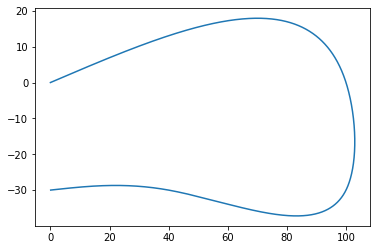

In [14]:
## INSERT CODE HERE
plt.plot(trkdata['x'], trkdata['y'])

## 2. Querbeschleunigung

Um das Fahrzeug sicher zu bewegen, sollte es mit deutlicher Reserve zum fahrdynamischen Grenzbereich betrieben werden. Die bedeutet, dass der Betriebsbereich deutlich innerhalb des **Kammschen Kreises** (siehe Vorlesung) liegen sollte.

Wir nehmen nun an, dass die Sollspur mit konstanter Geschwindigkeit befahren werden soll (d.h. Längsbeschleunigung $a_x = 0$) und die Querbeschleunigung $a_y$ im stabilen Bereich $6 m/s^2$ niemals übersteigen darf. 

### A3.2

Aus diesen Annahmen lässt sich  die maximale Geschwindigkeit ```v_soll``` bestimmen, mit der das Fahrzeug die Sollspur befahren kann:
1. Nehmen Sie zunächst an, dass ```v_soll=40km/h``` gilt. 
2. Berechnen Sie nun für diese Geschwindigkeit ```v_soll``` die resultierende Querbeschleunigung $a_y$ des Fahrzeugs entlang der Sollspur. Verwenden Sie dazu die Näherungsformel für eine Kreisfahrt mit konstanter Geschwindigkeit (siehe Vorlesung): \begin{eqnarray} \dot{\psi} &=& v_{soll} \, / \, r \\
\rightarrow \;\;\;\; a_y &=& v_{soll} \,\dot{\psi} = v_{soll}^2 \, / \, r \end{eqnarray} bzw. mit der Krümmung $\kappa = 1/r$: \begin{equation}
a_y = v_{soll}^2 \, \kappa \,.
\end{equation} Visualisieren Sie $a_y$ mit Hilfe von ```plt.plot```. Ist die Sollspur mit ```v_soll=40km/h``` fahrbar?
3. Bestimmen Sie durch ausprobieren eine möglichst hohe, aber dennoch fahrbare Sollgeschwindigkeit ``v_soll``.

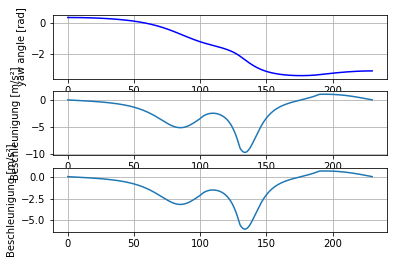

In [15]:
plt.subplot(3,1,1)
plt.plot(trkdata['s'], np.unwrap(trkdata['yaw']), "b", label="yaw")
plt.ylabel("yaw angle [rad]")
plt.grid(True)

plt.subplot(3,1,2)

## INSERT CODE HERE
v_soll = 40 / 3.6
ay = v_soll**2 * trkdata['curvature']
plt.plot(trkdata['s'], ay)
plt.ylabel("Beschleunigung [m/s²]")
plt.grid(True)

plt.subplot(3,1,3)
v_desired = np.sqrt(-6 / trkdata['curvature'][np.argmax(abs(ay))])
ay_max = v_desired**2 * trkdata['curvature']
plt.plot(trkdata['s'], ay_max)
plt.ylabel("Beschleunigung [m/s²]")
plt.grid(True)

## 3. Fahrdynamikmodell

In der Bibliothek ``vehicle_model.py`` ist eine Klasse ``State`` definiert, mit der ein Fahrzeug simuliert werden kann.

Diese Klasse hat folgende wichtige Funktion:

```
State.__init__(x=0.0, y=0.0, yaw=0.0, v=0.0, t=0.0):
    Constructor setting the inital position (x,y), orientation (yaw), 
    speed of the vehicle (v), and initial simulation time (t).
        
State.update(acceleration, delta):
    Update the state of the vehicle.
    Parameter: acceleration: (float) acceleration
               delta: (float) steering
```

und der Zustand des Fahrzeugs wird durch folgende Variablen beschrieben:

```
State.t: (float) current time
State.x: (float) x-coordinate
State.y: (float) y-coordinate
State.yaw: (float) yaw angle
State.v: (float) speed
State.beta: (float) slip angle
State.dyaw_dt: (float) time derivative of slip angle
```


### A 3.3

Sehen Sie sich das unten angegebene Beispiel für die Verwendung der Klasse ``State`` an.

Testen Sie den Simulator, indem Sie andere Stellsignale (Lenkwinkel und Beschleunigung) verwenden.

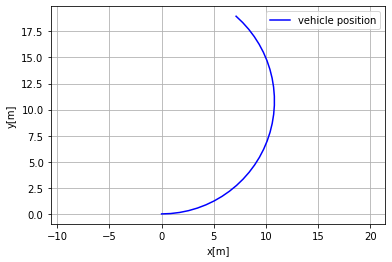

In [16]:
# Load the following functions and constants from vehicle_model.py:
#   State: a class for simulating the motion of a vehicle.
#   normalize_angle: normalize an angle to [-pi, pi].
#   veh_dim_x, veh_dim_y: [m] size of simulated vehicle (length, width)
#   L: [m] Wheel base of vehicle
from vehicle_model import State, normalize_angle, veh_dim_x, veh_dim_y, L


## MODIFY HERE FOR EVALUATION
S = State(v=v_desired)
x, y = [S.x], [S.y]
for i in range(30):
    S.update(acceleration=0, delta=np.radians(15.0))
    x.append(S.x)
    y.append(S.y)
    
plt.plot(x, y, "b", label="vehicle position")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)

## 4. Längsregelung

Für die Längsregelung soll ein einfacher P-Regler implementiert werden, der als Eingang die Sollgeschwindigkeit und die Ist-Geschwindigkeit aufnimmt.

### A3.4

Vervollständigen Sie dazu den untenstehenden Code. 

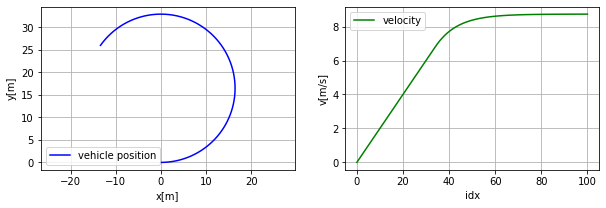

In [17]:
Kp = 1.0  # speed propotional gain

def speed_control(target, current):
    """
    Proportional control for the speed.
    :param target: target speed (m/s)
    :param current: current speed (m/s)
    :return: controller output (m/ss)
    """
    ## INSERT CODE HERE
    return (target - current) * Kp
    
    ## END INSERTED CODE

S = State(v=0)
x, y, v = [S.x], [S.y], [S.v]
for i in range(100):
    acc = speed_control(v_desired, S.v)
    S.update(acceleration=acc, delta=np.radians(10.0))
    x.append(S.x)
    y.append(S.y)
    v.append(S.v)
    
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(x, y, "b", label="vehicle position")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)  

plt.subplot(1,2,2)
plt.plot(v, "g", label="velocity")
plt.legend()
plt.xlabel("idx")
plt.ylabel("v[m/s]")
plt.grid(True)

## 5. Querregelung mit dem dem Stanley-Regler

Für den Querregler muss aus den durch diskrete Punkte vorgegebenen Spurverlauf zunächst der aktuelle Querversatz berechnet werden:
![calcIndex.png](https://drive.google.com/uc?id=1mDOq3lLrQPgraxkdItuuFBBq5bii9sNx)

Dies geschieht mit Hilfe der Funktion ```calc_target_index(state, cx, cy, cyaw)```. Veranschaulichen Sie sich, was dieser Code berechnet und zurückgibt.

In [18]:
def calc_target_index(state, cx, cy, cyaw):
    """
    Compute index in the trajectory list of the target.

    :param state: (State object)
    :param cx: [m] x-coordinates of (sampled) desired trajectory
    :param cy: [m] y-coordinates of (sampled) desired trajectory
    :param cyaw: [rad] tangent angle of (sampled) desired trajectory
    :return: (int, float)
    """
    # Calc front axle position
    fx = state.x + 0.5 * L * np.cos(state.yaw)
    fy = state.y + 0.5 * L * np.sin(state.yaw)

    # Search nearest point index
    dx_vec = fx - np.asarray(cx).reshape([-1,1])
    dy_vec = fy - np.asarray(cy).reshape([-1,1])
    dist = np.hstack([dx_vec, dy_vec])
    dist_2 = np.sum(dist**2, axis=1)
    target_idx = np.argmin(dist_2)

    # Project RMS error onto front axle vector
    front_axle_vec = [np.cos(cyaw[target_idx] + np.pi / 2),
                      np.sin(cyaw[target_idx] + np.pi / 2)]
    error_front_axle = np.dot(dist[target_idx,:], front_axle_vec)

    return target_idx, error_front_axle

### A3.5

Vervollständigen Sie mit den Unterlagen aus der Vorlesung folgende Funktion für den Stanley-Regler.

Hinweis: Achten Sie darauf, die Winkeldifferenz $\psi_d$ mit Hilfe der Funktion ```normalize_angle```zu normalisieren.

In [19]:
k = 0.7  # control gain

def stanley_control(state, cx, cy, cyaw, last_target_idx):
    """
    Stanley steering control.

    :param state: (State object)
    :param cx: [m] x-coordinates of (sampled) desired trajectory
    :param cy: [m] y-coordinates of (sampled) desired trajectory
    :param cyaw: [rad] orientation of (sampled) desired trajectory
    :param last_target_idx: [int] last visited point on desired trajectory
    :return: ([rad] steering angle, 
        [int] last visited point on desired trajectory, 
        [m] cross track error at front axle)
    """
    current_target_idx, error_front_axle = calc_target_index(state, cx, cy, cyaw)

    # make sure that we never match a point on the desired path 
    # that we already passed earlier:
    if last_target_idx >= current_target_idx:
        current_target_idx = last_target_idx

    ## INSERT CODE HERE
    delta = normalize_angle(cyaw[current_target_idx] - state.yaw) + np.arctan2(-k * error_front_axle, state.v)
    
    ## END INSERTED CODE

    return delta, current_target_idx, error_front_axle

## Putting it all together

### A3.6

Kombinieren Sie nun beide Regler, um der gegebenen Spur zu folgen. Beachten Sie dabei die resultierenden Querabweichungen.

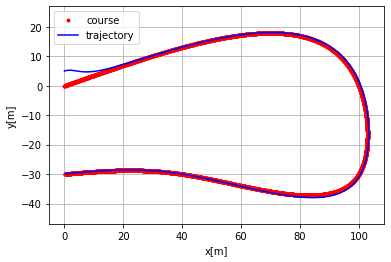

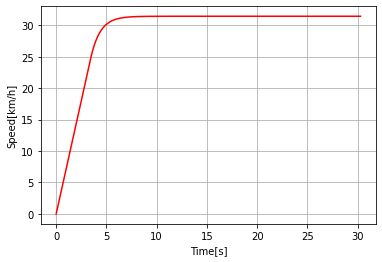

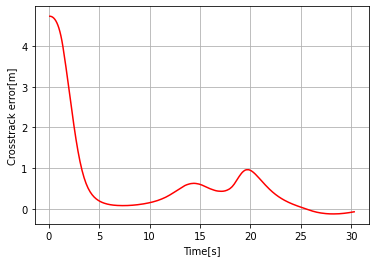

In [23]:
target_speed = v_desired
max_simulation_time = 100.0

# Initial state
state = State(x=-0.0, y=5.0, yaw=np.radians(20.0), v=0.0)

last_idx = len(trkdata['x']) - 1
time = 0.0
x = [state.x]
y = [state.y]
v = [state.v]
yaw = [state.yaw]
t = [state.t]
e_track = [np.nan]
target_idx, _ = calc_target_index(state, trkdata['x'], trkdata['y'], trkdata['yaw'])

while max_simulation_time >= state.t and last_idx > target_idx:
    ## INSERT CODE HERE
    di, target_idx, dlat = stanley_control(state=state, cx= trkdata['x'], cy= trkdata['y'], cyaw= trkdata['yaw'], last_target_idx=target_idx)
    ai = speed_control(target_speed, v[-1])
    ## END INSERTED CODE
    state.update(ai, di)

    x.append(state.x)
    y.append(state.y)
    v.append(state.v)
    yaw.append(state.yaw)
    t.append(state.t)
    e_track.append(dlat)

# Test
assert last_idx >= target_idx, "Cannot reach goal"

plt.plot(trkdata['x'], trkdata['y'], ".r", label="course")
plt.plot(x, y, "-b", label="trajectory")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)

plt.subplots(1)
plt.plot(t, [iv * 3.6 for iv in v], "-r")
plt.xlabel("Time[s]")
plt.ylabel("Speed[km/h]")
plt.grid(True)

plt.subplots(1)
plt.plot(t, e_track, "-r")
plt.xlabel("Time[s]")
plt.ylabel("Crosstrack error[m]")
plt.grid(True)

## 7. Animation

In den beiden folgenden Zellen befindet sich Code, mit dem Sie Ihr Regelungsergebnis als Animation betrachten können.

In [ ]:
def getVehicleContours(pos_x, pos_y, yaw):
    """Compute object contours."""

    L_2, W_2 = veh_dim_x/2.0, veh_dim_y/2.0
    u = np.array([
        [0, -W_2, 1],    # 1
        [L_2, -W_2, 1],  # 2
        [L_2, W_2, 1],   # 3
        [0, W_2, 1],     # 4
        [L_2, 0, 1],     # 5
        [0, -W_2, 1],    # 6
        [0, W_2, 1],     # 7
        [-L_2, W_2, 1],  # 8
        [-L_2, -W_2, 1],  # 9
        [0, -W_2, 1]     # 10
    ]).T

    T = np.array([
        [np.cos(yaw), -np.sin(yaw), pos_x],
        [np.sin(yaw), np.cos(yaw), pos_y]
    ])

    v = np.dot(T, u)
    return v[0, :], v[1, :]

In [ ]:
# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots(figsize=(8,8))
plt.close()
ax.axis("equal")
ax.grid(True)
ax.set_xlim((-10, 110))
ax.set_ylim((-60, 60))
course, = ax.plot([], [], "r.", label="course")
trajectory, = ax.plot([], [], "-b", label="trajectory")
vehicle, = ax.plot([], [], "b", label="vehicle")
title_text = ax.text(.7, .9, '', transform = ax.transAxes)

# initialization function: plot the background of each frame
def init():
    course.set_data(trkdata['x'], trkdata['y'])   
    return (course,)
  
# animation function: this is called sequentially
def animate(i):
    trajectory.set_data(x[:i], y[:i])
    px, py = getVehicleContours(x[i], y[i], yaw[i])
    vehicle.set_data(px, py)
    title_text.set_text(("Speed[km/h]:" + str(v[i] * 3.6)[:4]))
    return (trajectory, vehicle, title_text, )

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(x), 
                               interval=50, blit=True)

rc('animation', html='jshtml')
anim